# Training baseline models

## 1.) Training baseline for a combination of default MNIST and swiss MNIST datasets

To compare the results, a baseline model is trained on the combined data swiss and default mnist (*baseline_combined*). Default MNIST data are downsampled to match the number of samples in the swiss MNIST dataset. Training data (13,594 samples), validation data (1,699 samples) and test data (1,700 samples) are equally sized and merged into one set for training, validation and testing. The baseline model has the same architecture as the experts used in MoE architectures (*MnistNet*). The model is then saved under *./trained_models/baseline/baseline_combined.pth*.

In [2]:
import torch
import torchvision
import numpy as np

from models.mnist.mnist_net import MnistNet
from datasets.mnist_dataset import MNISTDataset
from utils.plot_confusion_matrix import plot_confusion_matrix
from utils.dataset_utils import train_test_split, build_subset, get_transformation

In [3]:
transformations_mnist_default = get_transformation('mnist')
transformations_mnist_swiss = get_transformation('swiss_mnist')

In [4]:
torch.manual_seed(42)

device = "cuda:0" if torch.cuda.is_available() else "cpu:0"
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam

In [23]:
# Load datasets
mnist_default_train = MNISTDataset('../../data/default_mnist/training', transform=transformations_mnist_default)
mnist_default_test = MNISTDataset('../../data/default_mnist/testing', transform=transformations_mnist_default)

mnist_swiss_train = MNISTDataset('../../data/swiss_mnist/training', transform=transformations_mnist_swiss)
mnist_swiss_test = MNISTDataset('../../data/swiss_mnist/testing', transform=transformations_mnist_swiss)

# Subsample default MNIST
mnist_default_train, _ = train_test_split(mnist_default_train, proportions=[len(mnist_swiss_train) / len(mnist_default_train), 0])
mnist_default_train, mnist_default_valid = train_test_split(mnist_default_train, [0.8, 0.2])
mnist_default_test, _ = train_test_split(mnist_default_test, proportions=[len(mnist_swiss_test) / len(mnist_default_test), 0])

mnist_swiss_train, mnist_swiss_valid = train_test_split(mnist_swiss_train, [0.8, 0.2])


# Combine datasets
combined_training = torch.utils.data.ConcatDataset([mnist_swiss_train, mnist_default_train])
combined_validation = torch.utils.data.ConcatDataset([mnist_swiss_valid, mnist_default_valid])
combined_test = torch.utils.data.ConcatDataset([mnist_swiss_train, mnist_default_test])

In [24]:
print('swiss_training_data: ', len(mnist_swiss_train))
print('swiss_validation_data: ', len(mnist_swiss_valid))
print('swiss_test_data: ', len(mnist_swiss_test))
print()

print('mnist_training_data: ', len(mnist_default_train))
print('mnist_validation_data: ', len(mnist_default_valid))
print('mnist_test_data: ', len(mnist_default_test))
print()

print('combined_training training: ', len(combined_training))
print('combined_validation: ', len(combined_validation))
print('combined_test: ', len(combined_test))

swiss_training_data:  11244
swiss_validation_data:  2812
swiss_test_data:  2337

mnist_training_data:  11244
mnist_validation_data:  2812
mnist_test_data:  2337

combined_training training:  22488
combined_validation:  5624
combined_test:  13581


In [26]:
baseline_combined = MnistNet(classes=[i for i in range(10)], name='baseline_combined')
# baseline_combined.load_state_dict(torch.load('./trained_models/baseline/baseline_combined.pth'))
baseline_combined.fit(
    training_data=combined_training,
    validation_data=combined_validation,
    num_epochs=50,
    batch_size=256,
    learning_rate=0.001,
    return_best_model=True,
    enable_logging=False
)

------------------------------------ Beginning Training ------------------------------------
Training of  baseline_combined
Training on device:  cuda:0
Training on 22,488 samples
Validation on 5,624 samples
Trainable parameters 421,642:
Total parameters 421,642:
Epoch 1/50
----------
training Loss: 0.0000  Accuracy: 0.7408
validation Loss: 0.0000  Accuracy: 0.9177

Epoch 2/50
----------
training Loss: 0.0000  Accuracy: 0.9009
validation Loss: 0.0000  Accuracy: 0.9499

Epoch 3/50
----------
training Loss: 0.0000  Accuracy: 0.9293
validation Loss: 0.0000  Accuracy: 0.9628

Epoch 4/50
----------
training Loss: 0.0000  Accuracy: 0.9462
validation Loss: 0.0000  Accuracy: 0.9651

Epoch 5/50
----------
training Loss: 0.0000  Accuracy: 0.9537
validation Loss: 0.0000  Accuracy: 0.9721

Epoch 6/50
----------
training Loss: 0.0000  Accuracy: 0.9611
validation Loss: 0.0000  Accuracy: 0.9716

Epoch 7/50
----------
training Loss: 0.0000  Accuracy: 0.9664
validation Loss: 0.0000  Accuracy: 0.9739

Ep

FileNotFoundError: [Errno 2] No such file or directory: '/home/lb4653/mixture-of-experts-thesis/experiments/mnist/wandb/run-20200629_121112-3c3t7854/baseline_combined_final.tar'

In [7]:
print('Baseline performance on mnist_test: ', baseline_combined.evaluate(mnist_test, 256, criterion, device))
print('Baseline performance on swiss_test: ', baseline_combined.evaluate(swiss_test, 256, criterion, device))
print('Baseline performance on combined_test: ', baseline_combined.evaluate(combined_test, 256, criterion, device))

Baseline performance on mnist_test:  {'loss': 0.081, 'acc': 0.9870588235294118, 'entropy': 0.0109, 'name': 'baseline_combined'}
Baseline performance on swiss_test:  {'loss': 0.0187, 'acc': 0.9958823529411764, 'entropy': 0.0206, 'name': 'baseline_combined'}
Baseline performance on combined_test:  {'loss': 0.0498, 'acc': 0.9914705882352941, 'entropy': 0.0157, 'name': 'baseline_combined'}


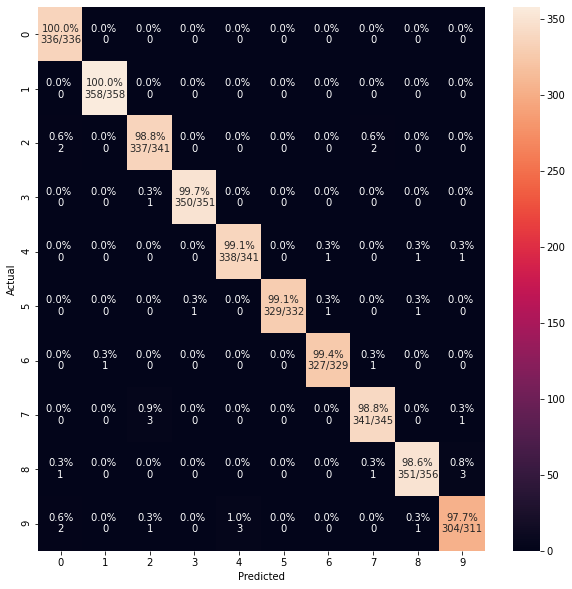

In [8]:
y_pred = baseline_combined.predict(combined_test, device)
y_swiss = np.array(combined_test.datasets[0].dataset.targets)[combined_test.datasets[0].indices]
y_default = np.array(combined_test.datasets[1].dataset.targets)[combined_test.datasets[1].indices]
y_true = np.concatenate((y_swiss, y_default))
plot_confusion_matrix(y_true, y_pred, [i for i in range(10)])

## 2.) Training baseline for default MNIST dataset

A second baseline model (*baseline_default*) is trained only on mnist data using the full dataset for training (40,000 samples), validation (10,000 samples) and testing (10,000 samples) to make it comparable in accordance with MoE models using only the default mnist data (without swiss mnist). The model has the same architecture as the experts (*MnistNet*). The model is then saved under *./trained_models/baseline/baseline_default.pth*.

In [9]:
# Preparing default mnist datasets using all samples
mnist_full_train = MNISTDataset('../../data/default_mnist/training', transform=transformations_mnist_default)
mnist_full_test = MNISTDataset('../../data/default_mnist/testing', transform=transformations_mnist_default)

mnist_full_train, mnist_full_valid = train_test_split(mnist_full_train, [0.8, 0.2])

In [10]:
baseline_mnist = MnistNet(classes=[i for i in range(10)], name='baseline_mnist')
baseline_mnist.load_state_dict(torch.load('./trained_models/baseline/baseline_default.pth'))
# baseline_mnist.fit(
#     training_data=mnist_full_train,
#     validation_data=mnist_full_valid,
#     num_epochs=50,
#     batch_size=128,
#     device=device,
#     criterion=criterion,
#     optimizer=optimizer,
#     learning_rate=0.001,
#     save_state_path='./trained_models/baseline/baseline_default.pth',
#     return_best_model=True
# )


<All keys matched successfully>

In [11]:
print('Default baseline performance on default_full_test: ', baseline_mnist.evaluate(mnist_full_test, 256, criterion, device))


Default baseline performance on default_full_test:  {'loss': 0.0373, 'acc': 0.992, 'entropy': 0.009, 'name': 'baseline_mnist'}


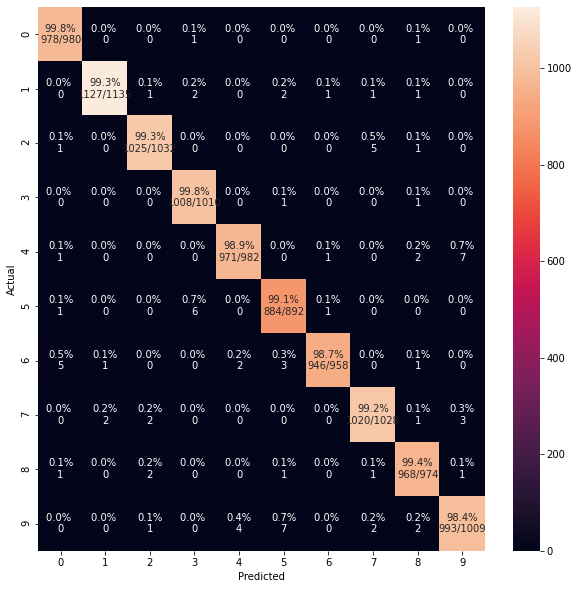

In [12]:
y_pred = baseline_mnist.predict(mnist_full_test, device)
y_true = np.array(mnist_full_test.targets)
plot_confusion_matrix(y_true, y_pred, [i for i in range(10)])